In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
from mnist import MNIST
mndata = MNIST('../HW1/mnistdata')
Train_images, Train_labels = mndata.load_training()
Test_images, Test_labels = mndata.load_testing()

Data Pre-Processing

In [3]:
Train_X = np.array(Train_images).T
Train_Y = np.array(Train_labels)   
Test_X = np.array(Test_images).T
Test_Y = np.array(Test_labels)

In [4]:
#data pre-processing
Train_X=Train_X/127.5-1
Test_X=Test_X/127.5-1
one=np.ones((1,Train_X.shape[1]))
Train_X=np.concatenate((one,Train_X),axis=0)
one=np.ones((1,Test_X.shape[1]))
Test_X=np.concatenate((one,Test_X),axis=0)

In [5]:
#shuffle data
shuffle_index = list(np.random.permutation(Train_X.shape[1]))
Train_X = Train_X[:, shuffle_index]
Train_Y = Train_Y[shuffle_index]

In [6]:
Valid_X=Train_X[:,50000:]
Train_X=Train_X[:,:50000]
Valid_Y=Train_Y[50000:]
Train_Y=Train_Y[:50000]


In [7]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x)) 

def cal_wx(w,x):
    return np.dot(w.T,x)


def cross_entropy(w,x,y):
    t=sigmoid(cal_wx(w,x)) # calculate activation
    cost_E= -1.0/(x.shape[1]) * np.sum(y*np.log(t)+(1-y)*np.log(1-t)) #calculate cost E
    dw = 1.0/(x.shape[1])*np.dot((y-t),x.T)
    return cost_E,dw

def softmax(a):
    a-=np.max(a,axis=0,keepdims=True) #stabilize
    sum_a=np.sum(np.exp(a),axis=0,keepdims=True)
    y_k= np.exp(a)/sum_a
    return y_k

def build_mask(y):
    mask=np.zeros((10,len(y)))
    mask[y,np.arange(len(y))] = 1
    return mask


def predict_softmax(w1,w2,b2,x,y):
    z = np.dot(w1.T,x)
    a1 = sigmoid(z)
    a= np.dot(w2.T,a1)+b2
    y_k = softmax(a)
    y_pred = y_k.argmax(axis=0)
    correct = [(a==b) for (a,b) in zip(y_pred,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

def predict_softmax_tanh(w1,w2,b2,x,y):
    z = np.dot(w1.T,x)
    a1 = tanh(z)
    a= np.dot(w2.T,a1)+b2
    y_k = softmax(a)
    y_pred = y_k.argmax(axis=0)
    correct = [(a==b) for (a,b) in zip(y_pred,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc



def mini_batches(x, y, mini_batch_size = 128):
    
    m = x.shape[1]                  
    mini_batches = []
        
    #calculate number of complete batches
    num_complete_minibatches = m//mini_batch_size 
    for k in range(0, num_complete_minibatches):
        mini_batch_x = x[:,k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_y = y[k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        end = m - mini_batch_size * math.floor(m / mini_batch_size)
        mini_batch_x = x[:,num_complete_minibatches * mini_batch_size:]
        mini_batch_y = y[num_complete_minibatches * mini_batch_size:]
        mini_batch = (mini_batch_x, mini_batch_y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def tanh(x):
    return 2*sigmoid(2*x)-1

In [8]:
# initilize
hidden_layer_units = 64
n_h = 64
n_x = Train_X.shape[0]
n_y = 10

In [9]:
 def cross_entro_soft(x,y,w2,a):
    a2= np.dot(w2.T,a)
    mask = build_mask(y)
    y_k = softmax(a2)
    E = -np.sum(np.log(y_k[y,np.arange(x.shape[1])]))/x.shape[1]/10
    dw2= 1.0*np.dot((mask-y_k),a.T)/a.shape[1]
    dhidden = np.dot(w2,(mask-y_k))
    dhidden[a <= 0] = 0
    #s = 1/(1+np.exp(-z))
    #temp = a * (1 - a)
    dw1 = np.dot((dhidden),x.T)/a.shape[1]
    return E,dw2,dw1

In [15]:
def loss(x, y,w1,w2,b2, reg=0.0):
    
    z = np.dot(w1.T,x)  # hidden layer
    a = sigmoid(z)      #sigmoid activation function
    a2 = np.dot(w2.T,a) +b2
    mask = build_mask(y)  #one hot coding
    y_k = softmax(a2)    
    E = -np.sum(np.log(y_k[y,np.arange(x.shape[1])]))/x.shape[1]/10 # cross entropy
    E+=0.5*reg*np.sum(w1**2)   
    E+=0.5*reg*np.sum(w2**2)
    
    #backprop
    dw2= 1.0*np.dot((mask-y_k),a.T)/a.shape[1]
    dhidden = np.dot(w2,(mask-y_k))
    temp = a * (1 - a)
    dw1 = np.dot((temp*dhidden),x.T)/a.shape[1]
    dw2 += reg * w2.T
    dw1 += reg * w1.T
    db2 = np.sum((mask-y_k), axis=1)/a.shape[1]

    return E, dw1,dw2,db2

In [16]:
def loss_tanh(x, y,w1,w2,b2, reg=0.0):
    
    z = np.dot(w1.T,x)  # hidden layer
    a0 = sigmoid(2*z)
    a = tanh(z)      #sigmoid activation function
    a2 = np.dot(w2.T,a) +b2
    mask = build_mask(y)  #one hot coding
    y_k = softmax(a2)    
    E = -np.sum(np.log(y_k[y,np.arange(x.shape[1])]))/x.shape[1]/10 # cross entropy
    E+=0.5*reg*np.sum(w1**2)   
    E+=0.5*reg*np.sum(w2**2)
    
    #backprop
    dw2= 1.0*np.dot((mask-y_k),a.T)/a.shape[1]
    dhidden = np.dot(w2,(mask-y_k))
    temp = 4*a0 * (1 - a0)
    dw1 = np.dot((temp*dhidden),x.T)/a.shape[1]
    dw2 += reg * w2.T
    dw1 += reg * w1.T
    db2 = np.sum((mask-y_k), axis=1)/a.shape[1]

    return E, dw1,dw2,db2

In [17]:
# w1 = np.random.randn(n_x,n_h)*0.001
# w2 = np.random.randn(n_h,n_y)*0.001
b2 = np.zeros((n_y,1)) #bias for w2
#fan-in
w1 = np.random.randn(n_x,n_h)/np.sqrt(50890)
w2 = np.random.randn(n_h,n_y)/np.sqrt(650)

#E, dw1,dw2 = loss(Train_X, Train_Y,w1,w2, reg=0.0)


In [18]:
#gradient check w1
def costplus(x,y, w1,w2,b2, epsilon=1e-2):
    w1_plus = w1
    w1_plus[0,10] = w1_plus[0,10]+epsilon
    cost_plus,_,_,_ = loss(x, y,w1_plus,w2,b2, reg=0.0)    
    return cost_plus

def costminus(x,y, w1,w2, b2,epsilon=1e-2):
    w1_minus = w1
    w1_minus[0,10] = w1_minus[0,10]-epsilon
    cost_minus,_,_,_ = loss(x, y,w1_minus,w2,b2, reg=0.0)    
    return cost_minus

def gradient_check(cost_p,cost_m,epsilon = 1e-2):
    slope = (cost_p - cost_m)*1.0 / (2 * epsilon)    
    return slope

In [19]:
cost_plus = costplus(Train_X,Train_Y, w1,w2,b2, epsilon=1e-2)
cost_minus = costminus(Train_X,Train_Y, w1,w2,b2, epsilon=1e-2)
slope = gradient_check(cost_plus,cost_minus,epsilon = 1e-2)
_,dw1,dw2,_ = loss(Train_X, Train_Y,w1,w2,b2, reg=0.0)
E,_,_,_=loss(Train_X,Train_Y, w1,w2,b2)
print slope
print dw1.T[0,10] - slope

-2.69604608943e-05
0.000566091028036


In [15]:
#gradient check w1
def costplus_w2(x,y, w1,w2,b2, epsilon=1e-2):
    w2_plus = w2
    w2_plus[0,0] = w2_plus[0,0]+epsilon
    cost_plus,_,_,_ = loss(x, y,w1,w2_plus,b2, reg=0.0)    
    return cost_plus

def costminus_w2(x,y, w1,w2, b2,epsilon=1e-2):
    w2_minus = w2
    w2_minus[0,0] = w2_minus[0,0]-epsilon
    cost_minus,_,_,_ = loss(x, y,w1,w2_minus,b2, reg=0.0)    
    return cost_minus


In [16]:
cost_plus = costplus_w2(Train_X,Train_Y, w1,w2,b2, epsilon=1e-2)
cost_minus = costminus_w2(Train_X,Train_Y, w1,w2,b2, epsilon=1e-2)
slope = gradient_check(cost_plus,cost_minus,epsilon = 1e-2)
print slope


0.000684039639448


slope is in range less than 10e-4,so the gradient is right.

In [18]:

def mini_optimize_reg_softmax(w1,w2,b2, x, y, x_hold,y_hold, x_test,y_test,num_epochs, learning_rate ,reg,mini_batch_size):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    cost_epoch = []
    v1 = np.zeros_like(w1)
    v2 = np.zeros_like(w2)
    v3 = np.zeros_like(b2)
    alpha = 0.9
    for i in range(num_epochs):
        
        #shuffle data
        shuffle_index = list(np.random.permutation(x.shape[1]))
        x = x[:, shuffle_index]
        y = y[shuffle_index]
        minibatches = mini_batches(x, y, mini_batch_size )
        
        for minibatch in minibatches:
            (minibatch_x, minibatch_y) = minibatch
            _,dw1,dw2,db2 = loss_tanh(minibatch_x, minibatch_y,w1,w2,b2, reg=reg)
            
    
            #updata gradients and learning rate decay            
            w1 += learning_rate*dw1.T
            w2 += learning_rate*dw2.T
            b2 += learning_rate*db2.reshape((10,1))
            learning_rate/=(1+i/1000) #learning rate decay
            
            
           # update with moment
#             v1 = 0.9 * v1 - learning_rate * (-dw1).T
#             v2 = 0.9 * v2 - learning_rate * (-dw2).T
#             v3 = 0.9 * v3 - learning_rate * (-db2.reshape((10,1)))
            
#             w1  += v1
#             w2  += v2
#             b2  += v3
#             learning_rate/=(1+i/1000) #learning rate decay

            
        

        # Cost for train
        cost_E,_,_,_ = loss_tanh(x, y,w1,w2,b2, reg=reg)  
        
        # Cost for holdout
        cost_E_hold,_,_,_ = loss_tanh(x_hold, y_hold,w1,w2,b2, reg=reg) 
        
        
        #cost for test
        cost_E_test,_,_,_ = loss_tanh(x_test, y_test,w1,w2,b2, reg=reg) 
        
        #calculate accuracy 
        acc_train =predict_softmax_tanh(w1,w2,b2,x,y)
        acc_hold = predict_softmax_tanh(w1,w2,b2,x_hold,y_hold)
        acc_test = predict_softmax_tanh(w1,w2,b2,x_test,y_test)

        cost_epoch.append(cost_E_hold)
        
        #early stop
        if i > 3:
            if cost_epoch[-3:] == sorted(cost_epoch[-3:]):
                break
        

        # Record the costs and acc
        if i % 20 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            print "Train Cost after iteration %i: %f" %(i, cost_E)
            print "Accuracy for train is ", acc_train
           # print "Accuracy for hold is ", acc_hold
            #print "Accuracy for test is ", acc_test
            
        
    return  w1,w2,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

In [21]:
 w1,w2,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test = mini_optimize_reg_softmax(w1,w2,b2, Train_X, Train_Y, Valid_X,Valid_Y, Test_X,Test_Y,500, 0.005 ,0,mini_batch_size=128)

Train Cost after iteration 0: 0.138095
Accuracy for train is  0.74684
Train Cost after iteration 20: 0.027382
Accuracy for train is  0.9224
Train Cost after iteration 40: 0.021256
Accuracy for train is  0.93988
Train Cost after iteration 60: 0.017414
Accuracy for train is  0.95154
Train Cost after iteration 80: 0.014823
Accuracy for train is  0.95904
Train Cost after iteration 100: 0.012955
Accuracy for train is  0.96418
Train Cost after iteration 120: 0.011576
Accuracy for train is  0.96852
Train Cost after iteration 140: 0.010359
Accuracy for train is  0.97192
Train Cost after iteration 160: 0.009400
Accuracy for train is  0.97536
Train Cost after iteration 180: 0.008644
Accuracy for train is  0.97786


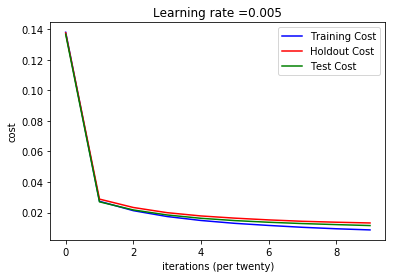

In [22]:
costs = np.squeeze(costs)
costs_hold = np.squeeze(costs_hold)
costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations (per twenty)')
plt.title("Learning rate =" + str(0.005))
plt.legend()
plt.show()

In [23]:
print accuracy_train[-1],accuracy_hold[-1],accuracy_test[-1]

0.97786 0.9611 0.9671


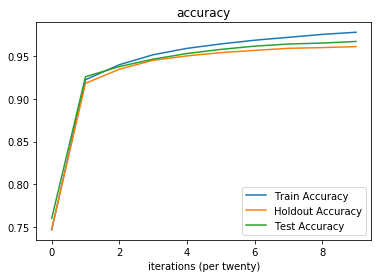

In [24]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')
plt.xlabel('iterations (per twenty)')
plt.title("accuracy")
plt.legend()
plt.show()

In [35]:
# 2 hidden layers
# initilize
#hidden_layer_units = 64
n_h1 = 64
n_h2 = 64
n_x = Train_X.shape[0]
n_y = 10
#fan-in
b3 = np.zeros((n_y,1)) #bias for w2
b2 = np.zeros((n_h2,1))
w1 = np.random.randn(n_x,n_h1)/np.sqrt(50890)
w2 = np.random.randn(n_h1,n_h2)/np.sqrt(4096)
w3 = np.random.randn(n_h2,n_y)/np.sqrt(640)

In [36]:
def loss_2hidden(x, y,w1,w2,w3,b2,b3, reg=0.0):
    
    z1 = np.dot(w1.T,x)
    a1 = sigmoid(z1)
    z2 = np.dot(w2.T,a1)+b2
    a2 = sigmoid(z2)
    z3 = np.dot(w3.T,a2)+b3
    #one hot coding
    mask = build_mask(y)
    y_k = softmax(z3)
    E = -np.sum(np.log(y_k[y,np.arange(x.shape[1])]))/x.shape[1]/10 
    E+=0.5*reg*np.sum(w1**2)
    E+=0.5*reg*np.sum(w2**2)
    E+=0.5*reg*np.sum(w3**2)

    #backprop
    dw3= 1.0*np.dot((mask-y_k),a2.T)/a2.shape[1]
    db3 = np.sum((mask-y_k), axis=1)/a2.shape[1]
    delta3 = mask-y_k
    temp2 = a2 * (1 - a2)
    delta2 = temp2*np.dot(w3,delta3)
    db2 = np.sum(delta2,axis =1)/a1.shape[1]
    dw2 = np.dot(delta2,a1.T)/a1.shape[1]
    
    temp1 = a1 * (1 - a1)
    delta1 = temp1*np.dot(w2,delta2)
    dw1 = np.dot(delta1,x.T)/x.shape[1]
    
    
    dw3 += reg * w3.T
    dw2 += reg * w2.T
    dw1 += reg * w1.T

    return E, dw1,dw2,dw3, db2,db3

In [37]:
def predict_softmax_hidden2(w1,w2,w3,b2,b3,x,y):
    z1 = np.dot(w1.T,x)
    a1 = sigmoid(z1)
    z2 = np.dot(w2.T,a1)+b2
    a2 = sigmoid(z2)
    z3 = np.dot(w3.T,a2)+b3
    y_k = softmax(z3)
    y_pred = y_k.argmax(axis=0)
    correct = [(a==b) for (a,b) in zip(y_pred,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

In [44]:
def mini_optimize_reg_softmax_hidden2(w1,w2,w3,b2,b3, x, y, x_hold,y_hold, x_test,y_test,num_epochs, learning_rate ,reg,mini_batch_size):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    cost_epoch = []
    v1 = np.zeros_like(w1)
    v2 = np.zeros_like(w2)
    v3 = np.zeros_like(w3)
    v4 = np.zeros_like(b2)
    v5 = np.zeros_like(b3)
    alpha = 0.9
    for i in range(num_epochs):
        #shuffle
        shuffle_index = list(np.random.permutation(x.shape[1]))
        x = x[:, shuffle_index]
        y = y[shuffle_index]
        minibatches = mini_batches(x, y, mini_batch_size )
        
        for minibatch in minibatches:
            (minibatch_x, minibatch_y) = minibatch
            _,dw1,dw2,dw3,db2,db3 = loss_2hidden(minibatch_x, minibatch_y,w1,w2,w3,b2,b3, reg=reg)

            
            #updata gradients and learning rate decay            
            #w1 += learning_rate*dw1.T
            #w2 += learning_rate*dw2.T
            #learning_rate/=(1+i/1000) #learning rate decay
            
            
            #update with moment
            v1 = 0.9 * v1 - learning_rate * (-dw1).T
            v2 = 0.9 * v2 - learning_rate * (-dw2).T
            v3 = 0.9 * v3 - learning_rate * (-dw3).T
            v4 = 0.9 * v4 - learning_rate * (-db2.reshape((64,1)))
            v5 = 0.9 * v5 - learning_rate * (-db3.reshape((10,1)))
            #updata
            w1  += v1
            w2  += v2
            w3  += v3
            b2  += v4
            b3  += v5
            
            learning_rate/=(1+i/1000) #learning rate decay

            
        

        # Cost for train
        cost_E,_,_,_,_,_ = loss_2hidden(x, y,w1,w2,w3,b2,b3 ,reg=0.0)  
        
        # Cost for holdout
        cost_E_hold,_,_,_,_,_ = loss_2hidden(x_hold, y_hold,w1,w2,w3,b2,b3 ,reg=0.0) 
        
        
        #cost for test
        cost_E_test,_,_,_,_,_ = loss_2hidden(x_test, y_test,w1,w2,w3,b2,b3, reg=0.0) 
        
        #calculate accuracy 
        acc_train =predict_softmax_hidden2(w1,w2,w3,b2,b3,x,y)
        acc_hold = predict_softmax_hidden2(w1,w2,w3,b2,b3,x_hold,y_hold)
        acc_test = predict_softmax_hidden2(w1,w2,w3,b2,b3,x_test,y_test)

        cost_epoch.append(cost_E_hold)
        
        #early stop
        if i > 3:
            if cost_epoch[-3:] == sorted(cost_epoch[-3:]):
                break
        

        # Record the costs and acc
        if i % 2 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            print "Train Cost after iteration %i: %f" %(i, cost_E)
            print "Accuracy for train is ", acc_train
           # print "Accuracy for hold is ", acc_hold
            #print "Accuracy for test is ", acc_test
            
        
    return  w1,w2,w3,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

In [45]:
 w1,w2,w3,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test = mini_optimize_reg_softmax_hidden2(w1,w2,w3,b2,b3, Train_X, Train_Y, Valid_X,Valid_Y, Test_X,Test_Y,200, 0.005,0.000,mini_batch_size=128)

Train Cost after iteration 0: 0.128621
Accuracy for train is  0.52296
Train Cost after iteration 2: 0.100693
Accuracy for train is  0.68964
Train Cost after iteration 4: 0.070012
Accuracy for train is  0.81496
Train Cost after iteration 6: 0.054752
Accuracy for train is  0.8582
Train Cost after iteration 8: 0.046377
Accuracy for train is  0.87892
Train Cost after iteration 10: 0.040584
Accuracy for train is  0.89298
Train Cost after iteration 12: 0.036410
Accuracy for train is  0.90358
Train Cost after iteration 14: 0.033051
Accuracy for train is  0.91114
Train Cost after iteration 16: 0.030293
Accuracy for train is  0.91894
Train Cost after iteration 18: 0.027468
Accuracy for train is  0.92652
Train Cost after iteration 20: 0.025416
Accuracy for train is  0.93172
Train Cost after iteration 22: 0.023543
Accuracy for train is  0.93612
Train Cost after iteration 24: 0.021864
Accuracy for train is  0.94014
Train Cost after iteration 26: 0.020465
Accuracy for train is  0.94412
Train Cost a

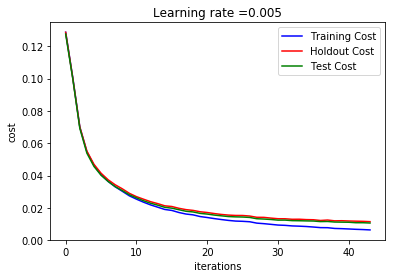

In [51]:
costs = np.squeeze(costs)
costs_hold = np.squeeze(costs_hold)
costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.005))
plt.legend()

plt.show()

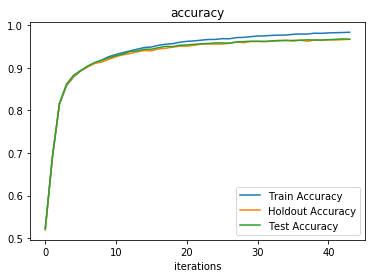

In [52]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')
plt.xlabel('iterations')
plt.title("accuracy")
plt.legend()
plt.show()

In [50]:
print accuracy_train[-1],accuracy_hold[-1],accuracy_test[-1]

0.98388 0.9674 0.9673


In [60]:
def loss_2hidden_relu(x, y,w1,w2,w3,b2,b3, reg=0.0):
    #forward 
    z1 = np.dot(w1.T,x)
    a1 = np.maximum(0,z1)
    z2 = np.dot(w2.T,a1)+b2
    a2 = np.maximum(0,z2)
    z3 = np.dot(w3.T,a2)+b3
    
    #one hot coding
    mask = build_mask(y)
    y_k = softmax(z3)
    #cross entropy
    E = -np.sum(np.log(y_k[y,np.arange(x.shape[1])]))/x.shape[1]/10
    E+=0.5*reg*np.sum(w1**2)
    E+=0.5*reg*np.sum(w2**2)
    E+=0.5*reg*np.sum(w3**2)
    
    #backprop
    dw3= 1.0*np.dot((mask-y_k),a2.T)/a2.shape[1]
    db3 = np.sum((mask-y_k), axis=1)/a2.shape[1]
    delta3 = mask-y_k
    dhidden2 =np.dot(w3,delta3)
    dhidden2[a2 <= 0] = 0
    delta2 = dhidden2
    db2 = np.sum(delta2,axis =1)/a1.shape[1]
    dw2 = np.dot(delta2,a1.T)/a1.shape[1]
    dhidden1 =np.dot(w2,delta2)
    dhidden1[a1 <= 0] = 0
    delta1 = dhidden1
    dw1 = np.dot(delta1,x.T)/x.shape[1]
    
    #regularizaiton
    dw3 += reg * w3.T
    dw2 += reg * w2.T
    dw1 += reg * w1.T

    return E, dw1,dw2,dw3,db2,db3

In [61]:
def predict_softmax_hidden2_relu(w1,w2,w3,b2,b3,x,y):
    z1 = np.dot(w1.T,x)
    a1 = np.maximum(0,z1)
    z2 = np.dot(w2.T,a1)+b2
    a2 = np.maximum(0,z2)
    z3 = np.dot(w3.T,a2)+b3
    y_k = softmax(z3)
    y_pred = y_k.argmax(axis=0)
    correct = [(a==b) for (a,b) in zip(y_pred,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

In [91]:
def mini_optimize_reg_softmax_hidden2_relu(w1,w2,w3,b2,b3, x, y, x_hold,y_hold, x_test,y_test,num_epochs, learning_rate ,reg,mini_batch_size):
    costs = []
    costs_hold = []
    costs_test = []
    accuracy_train = []
    accuracy_hold = []
    accuracy_test = []
    cost_epoch = []
    v1 = np.zeros_like(w1)
    v2 = np.zeros_like(w2)
    v3 = np.zeros_like(w3)
    v4 = np.zeros_like(b2)
    v5 = np.zeros_like(b3)
    alpha = 0.9
    for i in range(num_epochs):
        #shuffle
        shuffle_index = list(np.random.permutation(x.shape[1]))
        x = x[:, shuffle_index]
        y = y[shuffle_index]
        
        minibatches = mini_batches(x, y, mini_batch_size )
        
        for minibatch in minibatches:
            (minibatch_x, minibatch_y) = minibatch
            _,dw1,dw2,dw3,db2,db3 = loss_2hidden_relu(minibatch_x, minibatch_y,w1,w2,w3,b2,b3, reg=reg)

            
            #updata gradients and learning rate decay            
            #w1 += learning_rate*dw1.T
            #w2 += learning_rate*dw2.T
            #learning_rate/=(1+i/1000) #learning rate decay
            
            
            #update with moment
            v1 = 0.9 * v1 - learning_rate * (-dw1).T
            v2 = 0.9 * v2 - learning_rate * (-dw2).T
            v3 = 0.9 * v3 - learning_rate * (-dw3).T
            v4 = 0.9 * v4 - learning_rate * (-db2.reshape((64,1)))
            v5 = 0.9 * v5 - learning_rate * (-db3.reshape((10,1)))
            
            w1  += v1
            w2  += v2
            w3  += v3
            b2  += v4
            b3  += v5
            
            learning_rate/=(1+i/1000) #learning rate decay

            
        

        # Cost for train
        cost_E,_,_,_,_,_ = loss_2hidden_relu(x, y,w1,w2,w3,b2,b3, reg=0.0)  
        
        # Cost for holdout
        cost_E_hold,_,_,_,_,_ = loss_2hidden_relu(x_hold, y_hold,w1,w2,w3,b2,b3, reg=0.0) 
        
        
        #cost for test
        cost_E_test,_,_,_,_,_ = loss_2hidden_relu(x_test, y_test,w1,w2,w3,b2,b3, reg=0.0) 
        
        #calculate accuracy 
        acc_train =predict_softmax_hidden2_relu(w1,w2,w3,b2,b3,x,y)
        acc_hold = predict_softmax_hidden2_relu(w1,w2,w3,b2,b3,x_hold,y_hold)
        acc_test = predict_softmax_hidden2_relu(w1,w2,w3,b2,b3,x_test,y_test)

        cost_epoch.append(cost_E_hold)
        
        #early stop
        if i > 4:
            if cost_epoch[-4:] == sorted(cost_epoch[-4:]):
                break
        

        # Record the costs and acc
        if i % 1 == 0:
            costs.append(cost_E)
            costs_hold.append(cost_E_hold)
            costs_test.append(cost_E_test)
            accuracy_train.append(acc_train)
            accuracy_hold.append(acc_hold)
            accuracy_test.append(acc_test)
            print "Train Cost after iteration %i: %f" %(i, cost_E)
            print "Accuracy for train is ", acc_train
           # print "Accuracy for hold is ", acc_hold
            #print "Accuracy for test is ", acc_test
            
        
    return  w1,w2,w3,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test

In [106]:
# 2 hidden layers relu
# initilize
#hidden_layer_units = 128
n_h1 = 64
n_h2 = 64
n_x = Train_X.shape[0]
n_y = 10
#fan-in
w1 = np.random.randn(n_x,n_h1)/np.sqrt(50240)
w2 = np.random.randn(n_h1,n_h2)/np.sqrt(4096)
w3 = np.random.randn(n_h2,n_y)/np.sqrt(640)
b3 = np.zeros((n_y,1)) #bias for w2
b2 = np.zeros((n_h2,1))

In [107]:
 w1,w2,w3,costs,costs_hold,costs_test,accuracy_train,accuracy_hold,accuracy_test = mini_optimize_reg_softmax_hidden2_relu(w1,w2,w3,b2,b3, Train_X, Train_Y, Valid_X,Valid_Y, Test_X,Test_Y,50, 0.005 ,0.001,mini_batch_size=128)

Train Cost after iteration 0: 0.060112
Accuracy for train is  0.82198
Train Cost after iteration 1: 0.036624
Accuracy for train is  0.8943
Train Cost after iteration 2: 0.031180
Accuracy for train is  0.9082
Train Cost after iteration 3: 0.025042
Accuracy for train is  0.92628
Train Cost after iteration 4: 0.021595
Accuracy for train is  0.93686
Train Cost after iteration 5: 0.018737
Accuracy for train is  0.94558
Train Cost after iteration 6: 0.015569
Accuracy for train is  0.9549
Train Cost after iteration 7: 0.013947
Accuracy for train is  0.95954
Train Cost after iteration 8: 0.012599
Accuracy for train is  0.96284
Train Cost after iteration 9: 0.011580
Accuracy for train is  0.96596
Train Cost after iteration 10: 0.010934
Accuracy for train is  0.96772
Train Cost after iteration 11: 0.009746
Accuracy for train is  0.97104
Train Cost after iteration 12: 0.008970
Accuracy for train is  0.97304
Train Cost after iteration 13: 0.007828
Accuracy for train is  0.97668
Train Cost after it

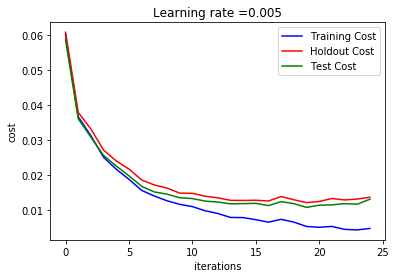

In [110]:
# costs = np.squeeze(costs)
# costs_hold = np.squeeze(costs_hold)
# costs_test = np.squeeze(costs_test)
plt.plot(costs,color = 'blue',label='Training Cost')
plt.plot(costs_hold,color = 'red',label='Holdout Cost')
plt.plot(costs_test,color = 'green',label='Test Cost')
plt.ylabel('cost')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.005))
plt.legend()
plt.show()

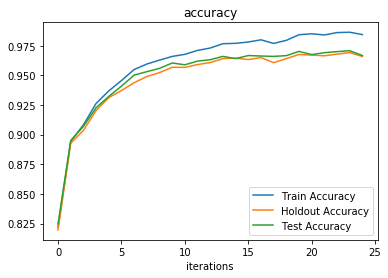

In [111]:
plt.plot(accuracy_train, label='Train Accuracy')
plt.plot(accuracy_hold, label='Holdout Accuracy')
plt.plot(accuracy_test,label='Test Accuracy')
plt.xlabel('iterations')
plt.title("accuracy")
plt.legend()
plt.show()

In [112]:
print accuracy_train[-1],accuracy_hold[-1],accuracy_test[-1]

0.98438 0.9659 0.9667
